<a href="https://colab.research.google.com/github/DiegoEscanciano/UCM_MACH/blob/main/C%C3%B3digo/Entrega_DiegoEscanciano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimación del precio de una vivienda 

En este notebook haremos un análisis exploratorio básico de la base de datos de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), para familiarizarnos con los datos y posteriormente aplicar técnicas de machine learning sobre ellos. 

Para cada vivienda, se tienen los siguientes atributos, características o features (o descriptores, o dimensiones...):

| Atributo | descripción |
| :- |:- |
|*id*| identificador de la vivienda|
| *date*| fecha
| *price*| precio
| *bedrooms*| número de habitaciones
| *bathrooms*| número de baños/aseos
| *sqtf_living*| superficie habitable (en pies al cuadrado)
| *sqft_lot*| superficie de la parcela (en pies al cuadrado)
| *floors*| número de plantas
| *waterfront*| indica si la vivienda tiene acceso a un lago
| *view*| tipo de vista (variable numérica)
| *condition*| condición de la vivienda (variable númerica)
| *grade*| medida de la calidad de la construcción (variable numérica)
| *sqft_above*| superficie por encima del suelo (en pies al cuadrado)
| *sqft_basement*| superficie del sótano (en pies al cuadrado)
| *yr_built*| año de construcción de la vivienda
| *yr_renovated*| año de renovación de la vivienda
| *lat*| latitud de la parcela
| *long*| longitud de la parcela
| *sqft_living15*| superficie habitable promedio de los 15 vecinos más cercanos 				
| *sqft_lot15*| superficie de la parcela promedio de los 15 vecinos más cercanos

Vamos a utilizar **DataFrames** de [Pandas](http://pandas.pydata.org/). Como es sabido, Pandas es un módulo de python de código abierto para el análisis de datos, que proporciona estructuras de datos fáciles de utilizar. Como guía de referencia básica, puede consultarse la [cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf)

In [1]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline


In [2]:
house_data = pd.read_csv("https://raw.githubusercontent.com/DiegoEscanciano/UCM_MACH/main/Data/kc_house_data.csv") # cargamos fichero
house_data.head().T                                   # visualizamos 5 primeras filas

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000,20150218T000000
price,221900.0,538000.0,180000.0,604000.0,510000.0
bedrooms,3,3,2,4,3
bathrooms,1.0,2.25,1.0,3.0,2.0
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1.0,2.0,1.0,1.0,1.0
waterfront,0,0,0,0,0
view,0,0,0,0,0


In [3]:
def remove_collinear_features(x, threshold):
    
    # Create correlation matrix:
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
    # Work through the iterations setup:
    for i in iters:
        for j in range(i+1):
            items = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = items.columns
            row = items.index
            val = abs(items.values)
            
            # Compare against threshold:
            if val >= threshold:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
                
    cols_to_drop = set(drop_cols)
    x = x.drop(columns = cols_to_drop, axis=1)
    
    return x

## Tratamiento de la base de datos inicial

In [4]:
house_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Podemos observar que todas las variables son de tipo numérico, así que no tenemos que codificar ninguna de ellas. Por otro lado, los atributos *id* y *date* no nos aportan información, así que los descartamos del DataFrame

In [5]:
# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

Además transforemos las variables de superficie para expresarlas en $m^2$ y posteriormente renombraremos las columnas.

In [6]:
# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

También puede resultar interesante añadir nuevas variables como la de años de la vivienda, definida como el año actual (2023) menos el año de construcción.

In [7]:
# añadimos las nuevas variables
house_data['years']            = 2023 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']

# visualizamos
house_data

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,68,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,72,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,90,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,58,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,36,9,6.00,5.050350,-5811.392356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,142.141651,105.073338,3.0,0,0,3,8,...,98103,47.6993,-122.346,142.141651,140.190687,14,9,7.50,4.956824,-5835.818558
21609,400000.0,4,2.50,214.606022,540.045372,2.0,0,0,3,8,...,98146,47.5107,-122.362,170.012563,668.901888,9,16,10.00,5.368804,-5813.504273
21610,402101.0,2,0.75,94.761101,125.419104,2.0,0,0,3,7,...,98144,47.5944,-122.299,94.761101,186.456401,14,4,1.50,4.551359,-5820.747526
21611,400000.0,3,2.50,148.644864,221.852460,2.0,0,0,3,8,...,98027,47.5345,-122.069,130.993286,119.566212,19,9,7.50,5.001560,-5802.488881


### Valores duplicados

Interesa eliminar los valores duplicados para evitar la redundancia en nuestros análisis. Para ello:

In [8]:
house_data[house_data.duplicated()==True] # Valores duplicados

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
3951,550000.0,4,1.75,223.896326,784.751979,2.0,0,3,4,8,...,98074,47.6499,-122.088,234.115661,1373.943059,87,16,7.00,5.411183,-5817.480991
4352,259950.0,2,2.00,99.406253,60.294073,2.0,0,0,3,9,...,98106,47.5213,-122.357,99.406253,86.214021,15,4,4.00,4.599215,-5814.563704
14983,585000.0,3,2.50,212.747962,472.783571,2.0,0,0,3,9,...,98006,47.5443,-122.172,212.747962,741.737871,22,9,7.50,5.360108,-5808.582220
20054,555000.0,3,2.50,180.231898,298.311661,2.0,0,0,3,8,...,98027,47.5644,-122.093,174.657715,285.955557,14,9,7.50,5.194244,-5807.280289
20524,529500.0,3,2.25,130.993286,84.077251,3.0,0,0,3,9,...,98116,47.5818,-122.402,140.283590,125.604910,9,9,6.75,4.875146,-5824.107484


Tenemos 5 valores duplicados en nuestro dataframe. El método a seguir en este caso es eliminarlos.

In [9]:
house_data=house_data.drop_duplicates()
house_data # Ahora tenemos 21608 registros en lugar de 21613

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,68,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,72,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,90,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,58,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,36,9,6.00,5.050350,-5811.392356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,142.141651,105.073338,3.0,0,0,3,8,...,98103,47.6993,-122.346,142.141651,140.190687,14,9,7.50,4.956824,-5835.818558
21609,400000.0,4,2.50,214.606022,540.045372,2.0,0,0,3,8,...,98146,47.5107,-122.362,170.012563,668.901888,9,16,10.00,5.368804,-5813.504273
21610,402101.0,2,0.75,94.761101,125.419104,2.0,0,0,3,7,...,98144,47.5944,-122.299,94.761101,186.456401,14,4,1.50,4.551359,-5820.747526
21611,400000.0,3,2.50,148.644864,221.852460,2.0,0,0,3,8,...,98027,47.5345,-122.069,130.993286,119.566212,19,9,7.50,5.001560,-5802.488881


### Análisis de datos missing

Vamos a llevar a cabo el análisis de datos missing.

In [10]:
#Distribución de los NaN's por columnas
pd_series_null_columns = house_data.isnull().sum().sort_values(ascending=False)
pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_por_columnas'])     
pd_null_columnas['porcentaje_nulos_por_columnas'] = pd_null_columnas['nulos_por_columnas']/house_data.shape[0]
pd_null_columnas

,nulos_por_columnas,porcentaje_nulos_por_columnas
price,0,0.0
bedrooms,0,0.0
log_sqm_living,0,0.0
bed_bath_rooms,0,0.0
bedrooms_squared,0,0.0
years,0,0.0
sqm_lot15,0,0.0
sqm_living15,0,0.0
long,0,0.0
lat,0,0.0


In [11]:
#Distribución de los NaN's por filas
pd_series_null_rows = house_data.isnull().sum(axis=1).sort_values(ascending=False)
pd_series_null_rows.sum()

0

Por tanto no tenemos valores nulos ni por filas ni por columnas en nuestro dataset house_data. Si hubieramos tenido alguno podríamos haberlos sustituido por la media (en caso de variables continuas) o la moda (en caso de variables discretas) entre otras posibilidades.

## Análisis Exploratorio

[Hacer un análisis exploratorio decente]

Realizamos ahora la matriz de correlaciones para ver si existe correlación entre los atributos para intentar evitar la colinealidad entre las variables, ya que en los algoritmos de machine learning esto suele inducir a error.

In [12]:
house_data.corr()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
price,1.000000,0.308326,0.525146,0.702035,0.089652,0.256893,0.266371,0.397409,0.036345,0.667541,...,-0.053179,0.307002,0.021587,0.585378,0.082435,-0.054062,0.210970,0.516627,0.611700,-0.265517
bedrooms,0.308326,1.000000,0.515956,0.576640,0.031671,0.175608,-0.006591,0.079411,0.028370,0.357143,...,-0.152683,-0.008970,0.129395,0.391571,0.029197,-0.154410,0.802087,0.802541,0.620835,0.053537
bathrooms,0.525146,0.515956,1.000000,0.754717,0.087751,0.500754,0.063747,0.187892,-0.124941,0.665029,...,-0.203837,0.024587,0.223065,0.568692,0.087192,-0.506038,0.335776,0.890182,0.761364,0.056643
sqm_living,0.702035,0.576640,0.754717,1.000000,0.172809,0.354181,0.103817,0.284627,-0.058825,0.762893,...,-0.199396,0.052514,0.240150,0.756398,0.183258,-0.318253,0.379532,0.777447,0.954322,0.037843
sqm_lot,0.089652,0.031671,0.087751,0.172809,1.000000,-0.005113,0.021598,0.074744,-0.008988,0.113688,...,-0.129595,-0.085683,0.229530,0.144596,0.718552,-0.053154,0.019292,0.075086,0.148846,0.156968
floors,0.256893,0.175608,0.500754,0.354181,-0.005113,1.000000,0.023731,0.029383,-0.263728,0.458074,...,-0.059153,0.049595,0.125592,0.280080,-0.011180,-0.489244,0.106168,0.384330,0.367794,0.000027
waterfront,0.266371,-0.006591,0.063747,0.103817,0.021598,0.023731,1.000000,0.401992,0.016648,0.082799,...,0.030283,-0.014272,-0.041916,0.086466,0.030698,0.026150,-0.001570,0.042194,0.079307,-0.001995
view,0.397409,0.079411,0.187892,0.284627,0.074744,0.029383,0.401992,1.000000,0.045819,0.251426,...,0.084857,0.006047,-0.078598,0.280391,0.072566,0.053196,0.056246,0.172059,0.246690,-0.033045
condition,0.036345,0.028370,-0.124941,-0.058825,-0.008988,-0.263728,0.016648,0.045819,1.000000,-0.144599,...,0.002998,-0.014975,-0.106590,-0.092920,-0.003449,0.361306,0.026895,-0.070029,-0.048218,-0.024238
grade,0.667541,0.357143,0.665029,0.762893,0.113688,0.458074,0.082799,0.251426,-0.144599,1.000000,...,-0.184875,0.114100,0.198496,0.713396,0.119319,-0.446887,0.218779,0.588113,0.743883,-0.031603


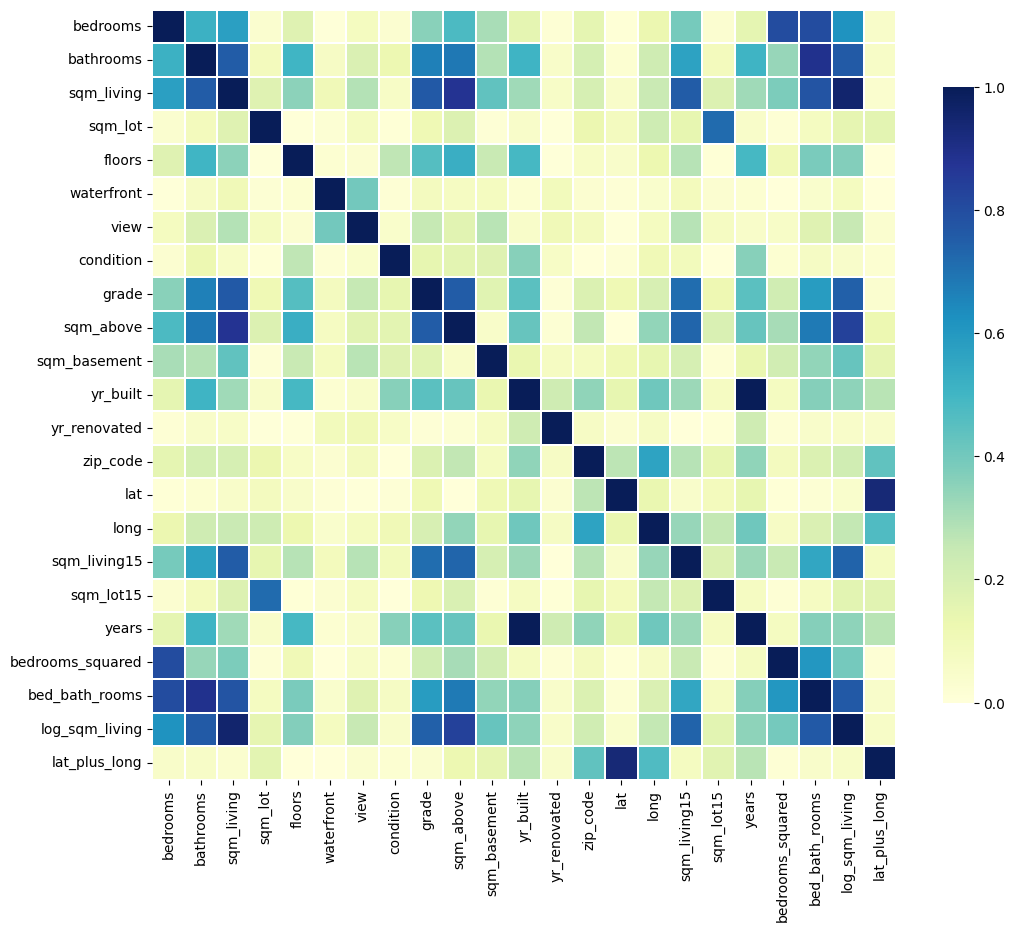

In [13]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(house_data.drop(['price'], axis=1).corr())

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

<Axes: >

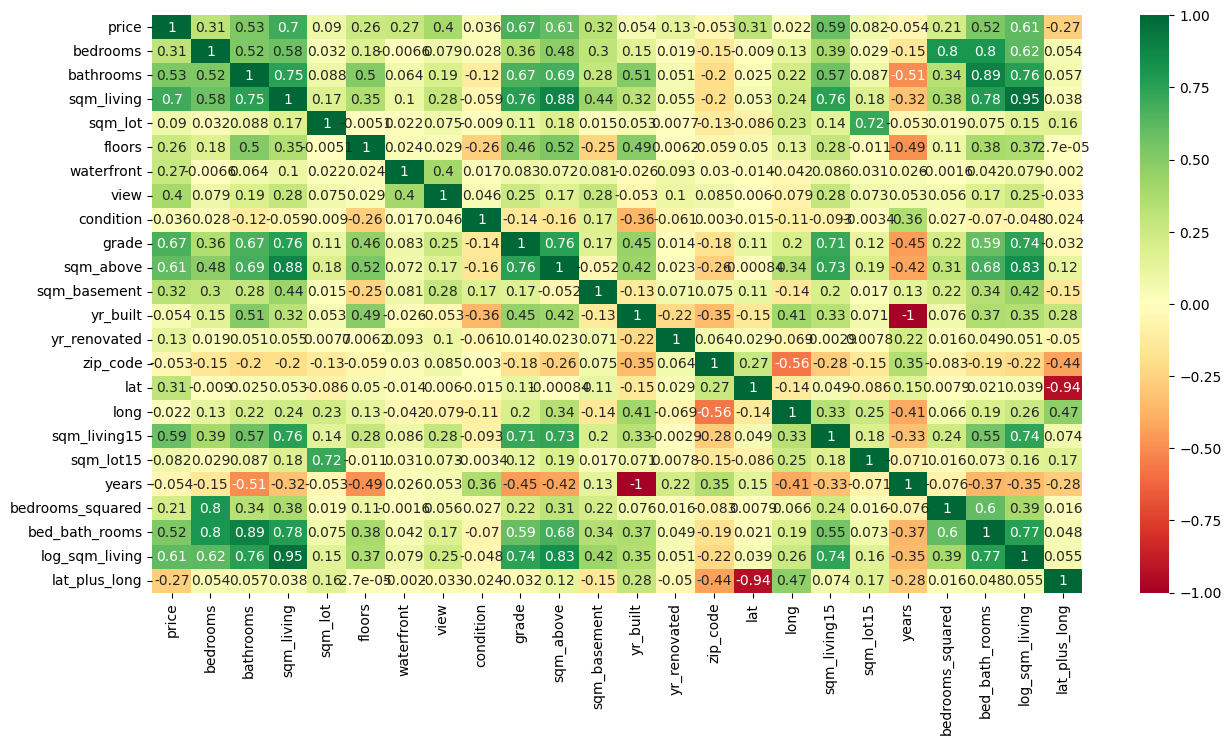

In [14]:
plt.figure(figsize=(15,7.5))
sns.heatmap(house_data.corr(), annot=True, vmin=-1, vmax=+1, cmap='RdYlGn')

Después de ver esta matriz de correlaciones hay muchas variables que podemos eliminar por redundancia respecto a otras. Podemos usar como valor límite un criterio del 0.7, es decir, que si la correlacion lineal es mayor que el 0.7 eliminamos la variable. Por ejemplo: years con yr_built.

Eliminaremos las variables yr_built, bed_bath_rooms, log_sqm_living, lat, long y resulta:

In [15]:
atributos=house_data.drop('price',axis=1)
remove_collinear_features(atributos, 0.7)

sqm_living | bathrooms | 0.75
grade | sqm_living | 0.76
sqm_above | sqm_living | 0.88
sqm_above | grade | 0.76
sqm_living15 | sqm_living | 0.76
sqm_living15 | grade | 0.71
sqm_living15 | sqm_above | 0.73
sqm_lot15 | sqm_lot | 0.72
years | yr_built | 1.0
bedrooms_squared | bedrooms | 0.8
bed_bath_rooms | bedrooms | 0.8
bed_bath_rooms | bathrooms | 0.89
bed_bath_rooms | sqm_living | 0.78
log_sqm_living | bathrooms | 0.76
log_sqm_living | sqm_living | 0.95
log_sqm_living | grade | 0.74
log_sqm_living | sqm_above | 0.83
log_sqm_living | sqm_living15 | 0.74
log_sqm_living | bed_bath_rooms | 0.77
lat_plus_long | lat | 0.94


,bedrooms,bathrooms,sqm_lot,floors,waterfront,view,condition,sqm_basement,yr_built,yr_renovated,zip_code,lat,long
0,3,1.00,524.902176,1.0,0,0,3,0.000000,1955,0,98178,47.5112,-122.257
1,3,2.25,672.803816,2.0,0,0,3,37.161216,1951,1991,98125,47.7210,-122.319
2,2,1.00,929.030400,1.0,0,0,3,0.000000,1933,0,98028,47.7379,-122.233
3,4,3.00,464.515200,1.0,0,0,5,84.541766,1965,0,98136,47.5208,-122.393
4,3,2.00,750.656563,1.0,0,0,3,0.000000,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,105.073338,3.0,0,0,3,0.000000,2009,0,98103,47.6993,-122.346
21609,4,2.50,540.045372,2.0,0,0,3,0.000000,2014,0,98146,47.5107,-122.362
21610,2,0.75,125.419104,2.0,0,0,3,0.000000,2009,0,98144,47.5944,-122.299
21611,3,2.50,221.852460,2.0,0,0,3,0.000000,2004,0,98027,47.5345,-122.069


In [16]:
atributos=atributos.drop(['sqm_living', 'grade', 'sqm_above', 'sqm_living15', 'sqm_lot15','bedrooms_squared','yr_built','bed_bath_rooms','log_sqm_living','lat_plus_long'], axis=1)

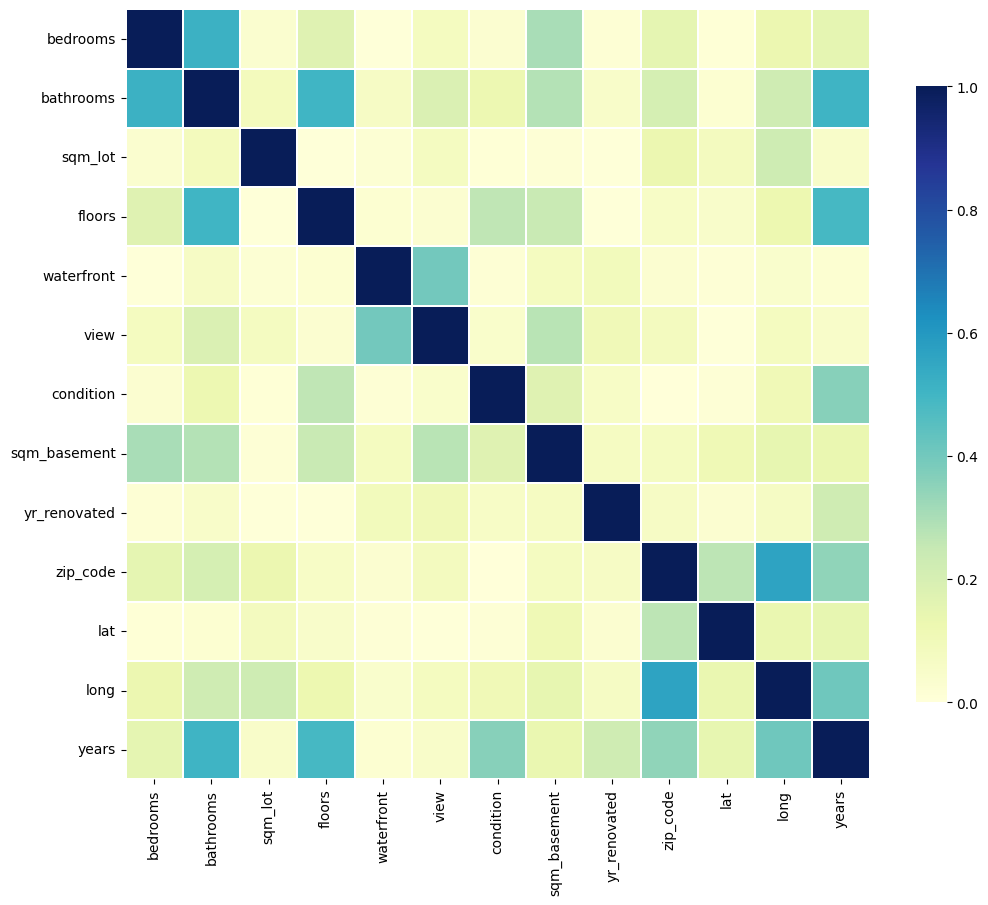

In [17]:
# Compute the correlation matrix
corr = np.abs(atributos.corr())

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

### Importancia de cada variable a la hora de clasificar la variable objetivo

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


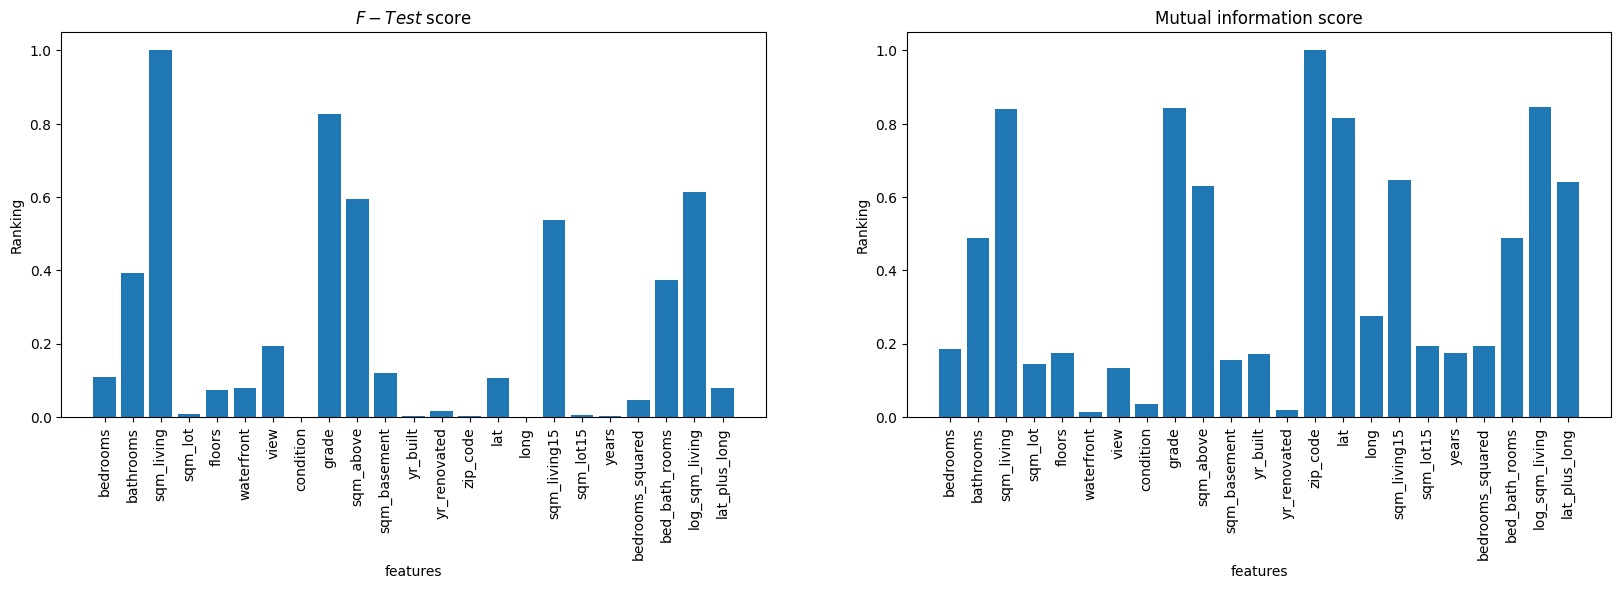

In [18]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

In [27]:
y = data[:,0:1]
y

array([[221900.],
       [538000.],
       [180000.],
       ...,
       [402101.],
       [400000.],
       [325000.]])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


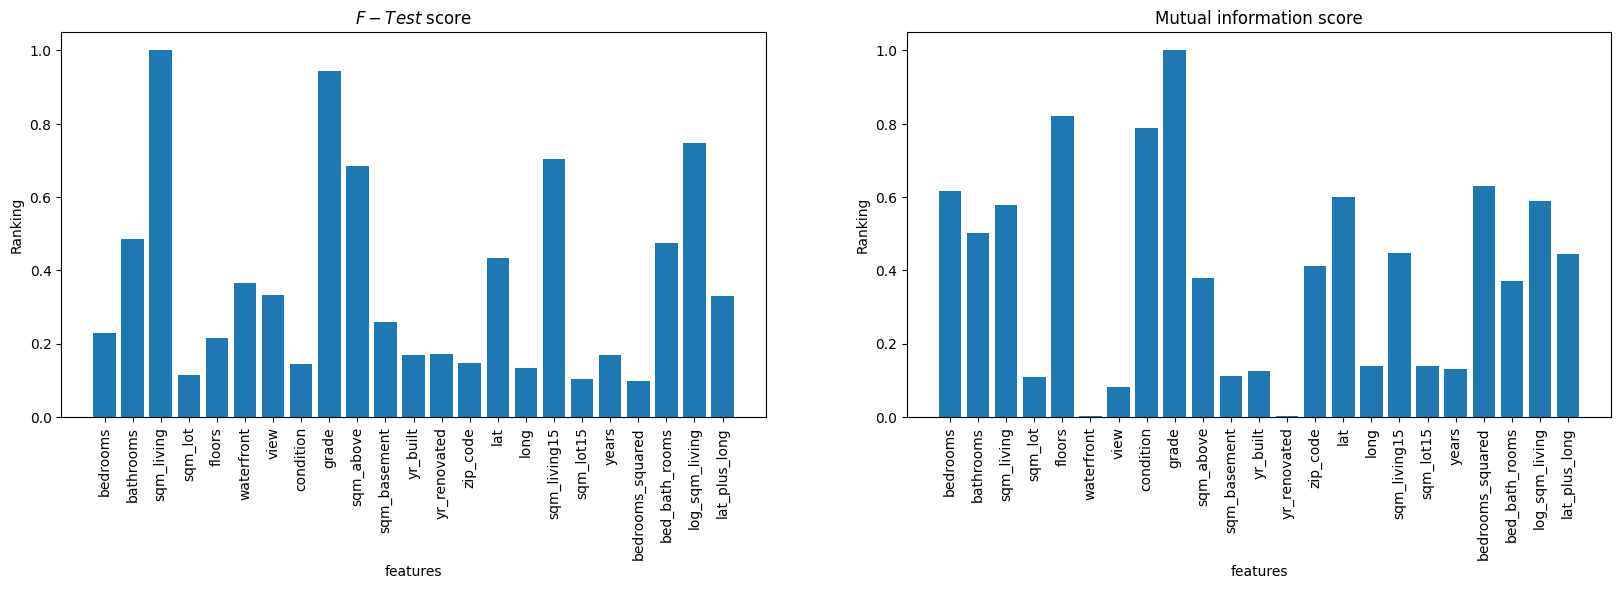

In [19]:
from sklearn.feature_selection import f_classif, mutual_info_classif

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]


# do calculations
f_test, _ = f_classif(X, y)
f_test /= np.max(f_test)

mi = mutual_info_classif(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

### Análisis de outliers

## Aplicación de algoritmos

In [20]:
from sklearn.model_selection import train_test_split

X = atributos
y = house_data['price'] # Variable objetivo

# Dividimos la muestra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (17286, 13)
Datos test:  (4322, 13)


Como nuestra variable objetivo es de tipo continua haremos análisis de regresión en lugar de análisis de clasificación. Además no podremos hacer balanceo de los datos como tal pues no tendremos clases enteras para cada valor de price.

### Modelo A: Regresión lineal

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lin_reg = LinearRegression()
model = lin_reg.fit(X_train, y_train)

linreg_y_pred = model.predict(X_test)
#val_pred = np.argmax(model.predict(X_test), axis=-1)
#linreg_y_pred=val_pred

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, linreg_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, linreg_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, linreg_y_pred)
print('MAE: ', mae)

RMSE:  258808.85472843482
R2 Score:  0.5295095384059141
MAE:  160561.63089227967


### Modelo B: Regresión K-NN

Búsqueda de hiperparámetros:

In [24]:
def plot_complexity_curve(k_list, knn_model, x_train, x_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k)
        
        knn.fit(x_train, y_train)
        
        train_scores.append(knn.score(x_train, y_train))
        test_scores.append(knn.score(x_test, y_test))

    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

In [25]:
neighbors = np.arange(1, 20)
plot_complexity_curve(neighbors, KNeighborsRegressor, X_train, X_test, y_train, y_test)

NameError: ignored

De la gráfica anterior concluimos que parece razonable tomar n_neighbors=15, ya que un numero mayor no mejora sustancialmente y requiere mucha más potencia computacional.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=15)
model = knn_reg.fit(X_train, y_train)

knn_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, knn_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, knn_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, knn_y_pred)
print('MAE: ', mae)

### Modelo C:  Arbol de decisión simple

Busqueda de hiperparámetros:

In [ ]:
for max_d in range(1,21):
  dt_reg = DecisionTreeRegressor(max_depth=max_d, random_state=42)
  model = dt_reg.fit(X_train, y_train)

  dt_y_pred = model.predict(X_test)

  print('The RMSE for max_depth {} is:'.format(max_d),  np.sqrt(mean_squared_error(y_test, dt_y_pred)))
  print('The RSQ for max_depth {} is:'.format(max_d),  r2_score(y_test, dt_y_pred))
  print('The MAE for max_depth {} is:'.format(max_d),  mean_absolute_error(y_test, dt_y_pred))

  np.sqrt(mean_squared_error(y_test, dt_y_pred))
  print('')

Por tanto tomaremos el hiperparámetro max_depth = 16.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(max_depth=16)
model = dt_reg.fit(X_train, y_train)

dt_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, dt_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, dt_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, dt_y_pred)
print('MAE: ', mae)

### Modelo D: Bagging

Busqueda de hiperparámetros:

In [ ]:
from sklearn.model_selection import GridSearchCV

maxDepth = range (1, 10)
param_grid = {'base_estimator__max_depth' : maxDepth}
grid = GridSearchCV(BaggingRegressor(estimator = DecisionTreeRegressor(), n_estimators = 200, random_state = 0), param_grid = param_grid, cv = 3, verbose = 2)
grid.fit (X_train, y_train)

In [ ]:
print ("best mean cross - validation score: {: .3f}".format(grid.best_score_))
print ("best parameters: {}".format(grid.best_params_))
scores = np.array (grid.cv_results_ ['mean_test_score'])
plt.plot (maxDepth, scores, '-o')
plt.xlabel ('max_depth', fontsize = 16)
plt.ylabel ('10-Fold MSE')
plt.show

Podemos tomar el hiperparametro 'max_depth' = 7.

In [ ]:
from sklearn.ensemble import BaggingRegressor

param_grid = {'base_estimator__max_depth' : 7}
b_reg = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=200, random_state=0)
model = b_reg.fit(X_train, y_train)

b_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, b_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, b_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, b_y_pred)
print('MAE: ', mae)

In [ ]:
from sklearn.ensemble import BaggingRegressor

b_reg = BaggingRegressor()
model = b_reg.fit(X_train, y_train)

b_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, b_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, b_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, b_y_pred)
print('MAE: ', mae)

### Modelo E: Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
model = rf_reg.fit(X_train, y_train)

rf_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, rf_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, rf_y_pred)
print('MAE: ', mae)

### Modelo F: GradientBoosting Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(random_state=0)
model = gb_reg.fit(X_train, y_train)

gb_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, gb_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, gb_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, gb_y_pred)
print('MAE: ', mae)

### Modelo G:  XGBoost Regression

In [ ]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
model = xgb_reg.fit(X_train, y_train)

xgb_y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
print('RMSE: ', rmse)
rsq = r2_score(y_test, xgb_y_pred)
print('R2 Score: ', rsq)
mae = mean_absolute_error(y_test, xgb_y_pred)
print('MAE: ', mae)

### Comparación de Modelos

Guararemos los resultados de todos los modelos anteriores en un dataset aparte para facilitar la comparativa entre todos ellos.

In [ ]:
scores = {
         'Model': ['Regresión lineal','K-NN','Árbol de decisión simple', 'Bagging', 'Random Forest', 'GradientBoost','XGBoost'],
          
         'RMSE': [(np.sqrt(mean_squared_error(y_test, linreg_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, knn_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, dt_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, b_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, rf_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, gb_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, xgb_y_pred))),],
    
         'R2 Score': [(r2_score(y_test, linreg_y_pred)),
                      (r2_score(y_test, knn_y_pred)),
                      (r2_score(y_test, dt_y_pred)),
                      (r2_score(y_test, b_y_pred)),
                      (r2_score(y_test, rf_y_pred)),
                      (r2_score(y_test, gb_y_pred)),
                      (r2_score(y_test, xgb_y_pred))],
    
        'MAE': [(mean_absolute_error(y_test, linreg_y_pred)),
                  (mean_absolute_error(y_test, knn_y_pred)),
                 (mean_absolute_error(y_test, dt_y_pred)),
                 (mean_absolute_error(y_test, b_y_pred)),
                 (mean_absolute_error(y_test, rf_y_pred)),
                 (mean_absolute_error(y_test, gb_y_pred)),
                 (mean_absolute_error(y_test, xgb_y_pred))]
            }

col = ['Model', 'RMSE', 'R2 Score', 'MAE']

error_matrix = pd.DataFrame(data=scores, columns=col).sort_values(by='MAE', ascending=True).reset_index()
error_matrix.drop(columns=['index'], inplace=True)

error_matrix

Reviewing the table above, there's a tie between the LGB and XGB models, which are both gradient boosters (neural networks) and have a MAE of $85,000. The LGB appears (very) marginally better than XGB, and therefore is my preferred choice of model. The accuracy rate is shown in the R2 score of 81%, which means that the model can explain 81% of calculated variances.

So that's it :). There are clearly many more sophisticated methods that can be used to achieve a higher level of predictive power. Intuitively, I would have liked a model with a maximum MAE of $25,000 for a problem on house prices, as it would generate very reliable predictions that can be used by a real-estate firm or prospective customers thinking about buying or selling a house in the area. Whilst neural networks can achieve this to some degree, some finetuning is required to take this exercise to the next level. So please review the kernel and let me know if you have any suggestions for improvement - Any constructive comments will be very gratefully received!!